$$D(x)=Wx+b$$
$$\mathcal L=\|D(x+\sigma z)-x\|^2$$
$$W,b=\arg\min_{W,b}\mathcal L$$

In [3]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

### Analytical theory learning curve

In [15]:
import torch
import numpy as np

def onelayer_learning_solu_scaling(tau, lambda_k, sigma, q_k, eta=1):
    """
    Compute ψ_k(τ) using NumPy.

    Parameters:
    - lambda_k (float or np.ndarray): λ_k values.
    - sigma (float): σ value.
    - eta (float): η value.
    - q_k (float or np.ndarray): q_k values.
    - tau (float or np.ndarray): τ values.

    Returns:
    - np.ndarray: Computed ψ_k(τ) values.
    """
    sigma_sq = sigma ** 2
    exponent = -2 * eta * (sigma_sq + lambda_k) * tau
    term1 = (lambda_k / (sigma_sq + lambda_k)) * (1 - np.exp(exponent))
    term2 = q_k * np.exp(exponent)
    return term1 + term2


def symmetric_two_layer_learning_solu_scaling(tau, lambda_k, sigma, q_k_0_norm, eta=1,):
    """
    Compute ψ_k(τ) using NumPy.

    Parameters:
    - lambda_k (float or np.ndarray): λ_k values.
    - sigma (float): σ value.
    - eta (float): η value.
    - q_k0 (float or np.ndarray): q_k0 values. If array-like, assumes each element corresponds to a different k.
    - tau (float or np.ndarray): τ values.

    Returns:
    - np.ndarray: Computed ψ_k(τ) values.
    """
    sigma_sq = sigma ** 2
    lambda_over_sigma_sq = lambda_k / (sigma_sq + lambda_k)
    exponent = -8.0 * eta * lambda_k * tau
    denominator = (lambda_over_sigma_sq - q_k_0_norm) * np.exp(exponent) + q_k_0_norm

    psi = lambda_over_sigma_sq * (q_k_0_norm / denominator)
    return psi


def symmetric_learning_solu_scaling(t, lambda_k, sigma, q_k_0_norm, eta=1,):
    # Ensure inputs are tensors for PyTorch operations
    t = torch.tensor(t, dtype=torch.float32)
    lambda_k = torch.tensor(lambda_k, dtype=torch.float32)
    sigma = torch.tensor(sigma, dtype=torch.float32)
    eta = torch.tensor(eta, dtype=torch.float32)
    q_k_0_norm = torch.tensor(q_k_0_norm, dtype=torch.float32)
    

    # Calculate the expression step by step
    term1 = torch.sqrt(lambda_k / (sigma**2 + lambda_k))
    exp_term = torch.exp(-8 * eta * lambda_k * t)
    denominator = torch.sqrt((lambda_k / (sigma**2 + lambda_k)) * exp_term + (1 - exp_term) * q_k_0_norm**2)
    result = (term1 / denominator) * q_k_0_norm
    return result


def symmetric_learning_loss(t, lambda_k, sigma, q_k_0_norm, eta=1,):
    # Ensure inputs are tensors for PyTorch operations
    t = torch.tensor(t, dtype=torch.float32)
    lambda_k = torch.tensor(lambda_k, dtype=torch.float32)
    sigma = torch.tensor(sigma, dtype=torch.float32)
    eta = torch.tensor(eta, dtype=torch.float32)
    q_k_0_norm = torch.tensor(q_k_0_norm, dtype=torch.float32)
    
    # Calculate the expression step by step
    diff_term = lambda_k / (sigma**2 + lambda_k) - q_k_0_norm ** 2 
    exp_term = torch.exp(-8 * eta * lambda_k * t)
    nominator = diff_term * exp_term
    denominator = diff_term * exp_term + q_k_0_norm**2
    result = (nominator / denominator) ** 2
    return result


def symmetric_learning_loss_weighted(t, lambda_k, sigma, q_k_0_norm, eta=1,):
    # Ensure inputs are tensors for PyTorch operations
    loss_curv = symmetric_learning_loss(t, lambda_k, sigma, q_k_0_norm, eta)
    weight = lambda_k ** 2 / (sigma ** 2 + lambda_k)
    return loss_curv * weight

In [2]:
from circuit_toolkit.plot_utils import saveallforms
figdir = '/n/home12/binxuwang/Github/DiffusionLearningCurve/figures'
figdir = "/Users/binxuwang/Library/CloudStorage/OneDrive-HarvardUniversity/Manuscript_DiffusionLearningCurve/Figures/Figure_theory_curves"

/Users/binxuwang/Github/circuit_toolkit/circuit_toolkit/GAN_invert_utils.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


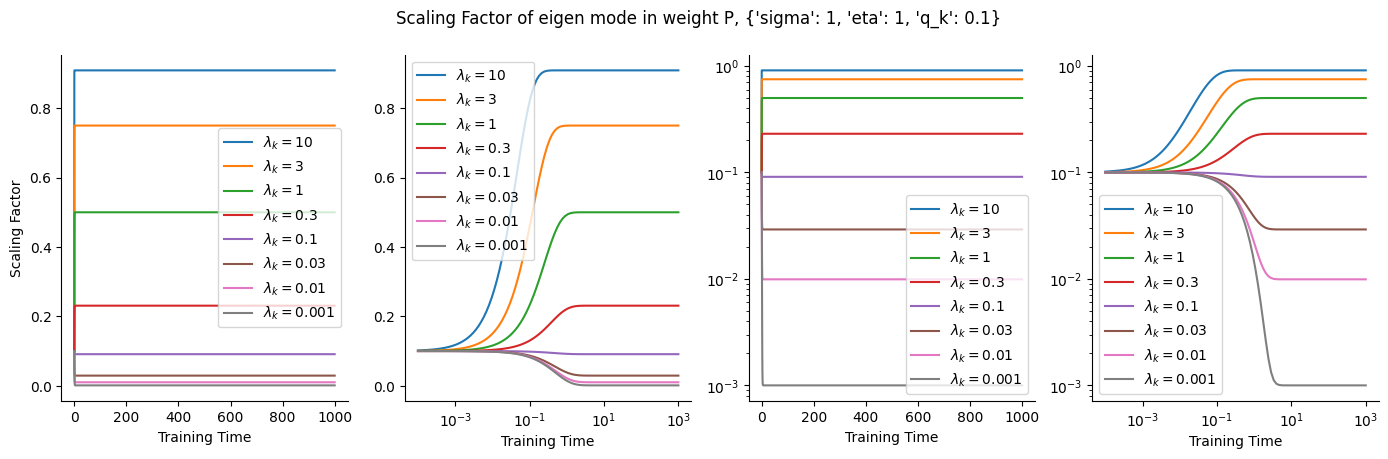

In [11]:
# t_vec = torch.linspace(0.001, 100, 1000)
parameters = dict(sigma=1, eta=1, q_k=0.1)
t_vec = torch.logspace(-4, 3, 100)
lambda_k_vec = [0.001, 0.01, 0.03, 0.1, 0.3, 1, 3, 10,][::-1]
figh, axs = plt.subplots(1, 4, figsize=(17, 4.5))
for ax, plot_fun in zip(axs, [plt.plot, plt.semilogx, plt.semilogy, plt.loglog]):
    plt.sca(ax)
    for lambda_k in lambda_k_vec:
        scaling_curve = onelayer_learning_solu_scaling(t_vec, lambda_k=lambda_k, **parameters)
        plot_fun(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$', )
    plt.xlabel('Training Time')
    if ax == axs[0]:
        plt.ylabel('Scaling Factor')
    plt.legend()
plt.suptitle(f'Scaling Factor of eigen mode in weight P, {parameters}')
saveallforms(figdir, f'one_layer_scaling_sigma{parameters["sigma"]:.1f}_qk{parameters["q_k"]:.2f}_fewer_lambda', figh)
plt.show()

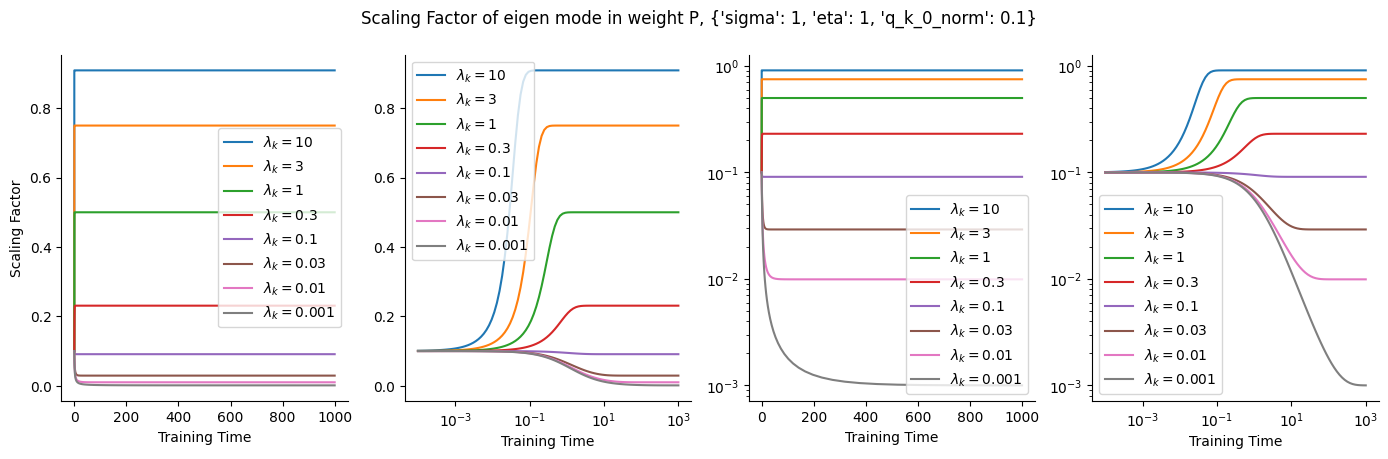

In [16]:
# t_vec = torch.linspace(0.001, 100, 1000)
parameters = dict(sigma=1, eta=1, q_k_0_norm=0.1)
t_vec = torch.logspace(-4, 3, 100)
lambda_k_vec = [0.001, 0.01, 0.03, 0.1, 0.3, 1, 3, 10,][::-1]
figh, axs = plt.subplots(1, 4, figsize=(17, 4.5))
for ax, plot_fun in zip(axs, [plt.plot, plt.semilogx, plt.semilogy, plt.loglog]):
    plt.sca(ax)
    for lambda_k in lambda_k_vec:
        scaling_curve = symmetric_two_layer_learning_solu_scaling(t_vec, lambda_k=lambda_k, **parameters)
        plot_fun(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$', )
    plt.xlabel('Training Time')
    if ax == axs[0]:
        plt.ylabel('Scaling Factor')
    plt.legend()
plt.suptitle(f'Scaling Factor of eigen mode in weight P, {parameters}')
saveallforms(figdir, f'symm_lrncrv_scaling_sigma{parameters["sigma"]:.1f}_qk{parameters["q_k_0_norm"]:.2f}_fewer_lambda', figh)
plt.show()

### Export figures

In [26]:
import os
from circuit_toolkit.plot_utils import saveallforms
figdir = "/Users/binxuwang/Library/CloudStorage/OneDrive-HarvardUniversity/Manuscript_DiffusionLearningCurve/Figures/Figure_theory_curves/weight_scaling"
os.makedirs(figdir, exist_ok=True)

In [21]:

def plot_weight_scaling_curves(tau_curve, std_curves, ylabel, figsize=(5, 5)):
    fig = plt.figure(figsize=figsize)
    for i, (lambdak, std_curve) in enumerate(std_curves):
        plt.plot(tau_curve, std_curve**2, label=f"$\lambda_k = {lambdak}$")
        # plt.axhline(y=lambdak, color=f'C{i}', linestyle='--')
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel(ylabel)
    plt.show()
    return fig

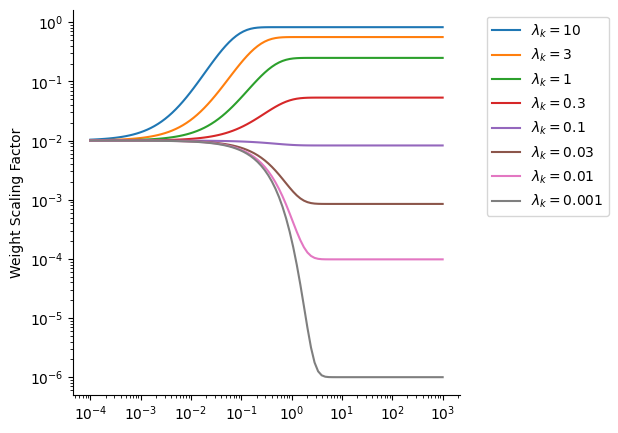

/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_30317/3972698316.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figh.show()


In [29]:
t_vec = torch.logspace(-4, 3, 100)
lambda_k_vec = [0.001, 0.01, 0.03, 0.1, 0.3, 1, 3, 10,][::-1]
parameters = dict(sigma=1, eta=1, q_k=0.1)
scaling_curves = []
for lambda_k in lambda_k_vec:
    scaling_curve = onelayer_learning_solu_scaling(t_vec, lambda_k=lambda_k, **parameters)
    scaling_curves.append((lambda_k, scaling_curve))
figh = plot_weight_scaling_curves(t_vec, scaling_curves, ylabel='Weight Scaling Factor')
figh.suptitle(f'One layer gradient flow Weight Scaling Factor, {parameters}')
saveallforms(figdir, f'one_layer_weight_scaling_sigma{parameters["sigma"]:.1f}_qk{parameters["q_k"]:.2f}_fewer_lambda_export', figh)
figh.show()

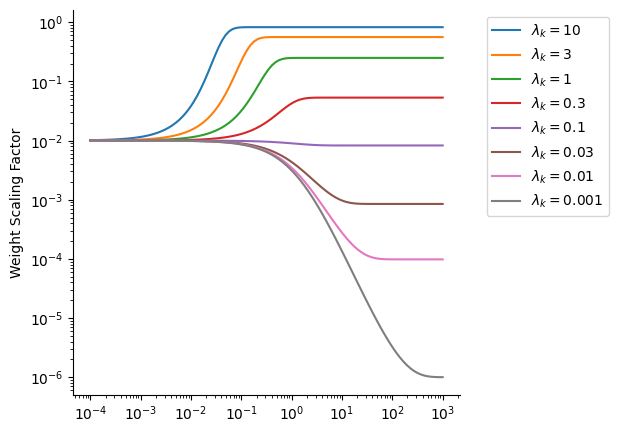

/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_30317/1591007243.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figh.show()


In [30]:
t_vec = torch.logspace(-4, 3, 100)
lambda_k_vec = [0.001, 0.01, 0.03, 0.1, 0.3, 1, 3, 10,][::-1]
parameters = dict(sigma=1, eta=1, q_k_0_norm=0.1)
scaling_curves = []
for lambda_k in lambda_k_vec:
    scaling_curve = symmetric_two_layer_learning_solu_scaling(t_vec, lambda_k=lambda_k, **parameters)
    scaling_curves.append((lambda_k, scaling_curve))
figh = plot_weight_scaling_curves(t_vec, scaling_curves, ylabel='Weight Scaling Factor')
figh.suptitle(f'Symmetric two layer gradient flow Weight Scaling Factor, {parameters}')
saveallforms(figdir, f'symm_two_layer_weight_scaling_sigma{parameters["sigma"]:.1f}_qk{parameters["q_k_0_norm"]:.2f}_fewer_lambda_export', figh)
figh.show()

In [ ]:
t_vec = torch.logspace(-4, 3, 100)
lambda_k_vec = [0.001, 0.01, 0.03, 0.1, 0.3, 1, 3, 10,][::-1]
for sigma in [0.1, 1, 10]:
    for q_k in [0.01, 0.1, 1]:
        parameters = dict(sigma=sigma, eta=1, q_k=q_k)
        scaling_curves = []
        for lambda_k in lambda_k_vec:
            scaling_curve = onelayer_learning_solu_scaling(t_vec, lambda_k=lambda_k, **parameters)
            scaling_curves.append((lambda_k, scaling_curve))
        figh = plot_weight_scaling_curves(t_vec, scaling_curves, ylabel='Weight Scaling Factor')
        figh.suptitle(f'One layer gradient flow Weight Scaling Factor, {parameters}')
        saveallforms(figdir, f'one_layer_weight_scaling_sigma{parameters["sigma"]:.1f}_qk{parameters["q_k"]:.2f}_fewer_lambda_export', figh)
        figh.show()
        
        parameters = dict(sigma=sigma, eta=1, q_k_0_norm=q_k)
        scaling_curves = []
        for lambda_k in lambda_k_vec:
            scaling_curve = symmetric_two_layer_learning_solu_scaling(t_vec, lambda_k=lambda_k, **parameters)
            scaling_curves.append((lambda_k, scaling_curve))
        figh = plot_weight_scaling_curves(t_vec, scaling_curves, ylabel='Weight Scaling Factor')
        figh.suptitle(f'Symmetric two layer gradient flow Weight Scaling Factor, {parameters}')
        saveallforms(figdir, f'symm_two_layer_weight_scaling_sigma{parameters["sigma"]:.1f}_qk{parameters["q_k_0_norm"]:.2f}_fewer_lambda_export', figh)
        figh.show()

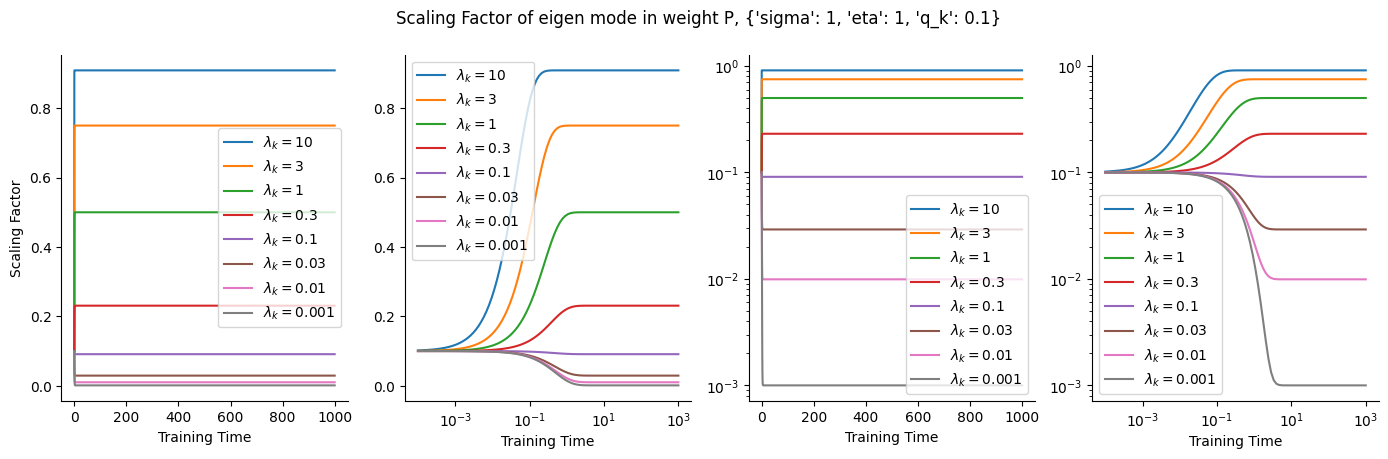

In [ ]:
# t_vec = torch.linspace(0.001, 100, 1000)
parameters = dict(sigma=1, eta=1, q_k=0.1)
t_vec = torch.logspace(-4, 3, 100)
lambda_k_vec = [0.001, 0.01, 0.03, 0.1, 0.3, 1, 3, 10,][::-1]
figh, axs = plt.subplots(1, 1, figsize=(5, 5))
for ax, plot_fun in zip(axs, [plt.plot, plt.semilogx, plt.semilogy, plt.loglog]):
    plt.sca(ax)
    for lambda_k in lambda_k_vec:
        scaling_curve = onelayer_learning_solu_scaling(t_vec, lambda_k=lambda_k, **parameters)
        plot_fun(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$', )
    plt.xlabel('Training Time')
    if ax == axs[0]:
        plt.ylabel('Magnitude of mode')
    plt.legend( anc)
plt.suptitle(f'Magnitude of eigen mode in weight W, {parameters}')
saveallforms(figdir, f'one_layer_scaling_sigma{parameters["sigma"]:.1f}_qk{parameters["q_k"]:.2f}_fewer_lambda', figh)
plt.show()

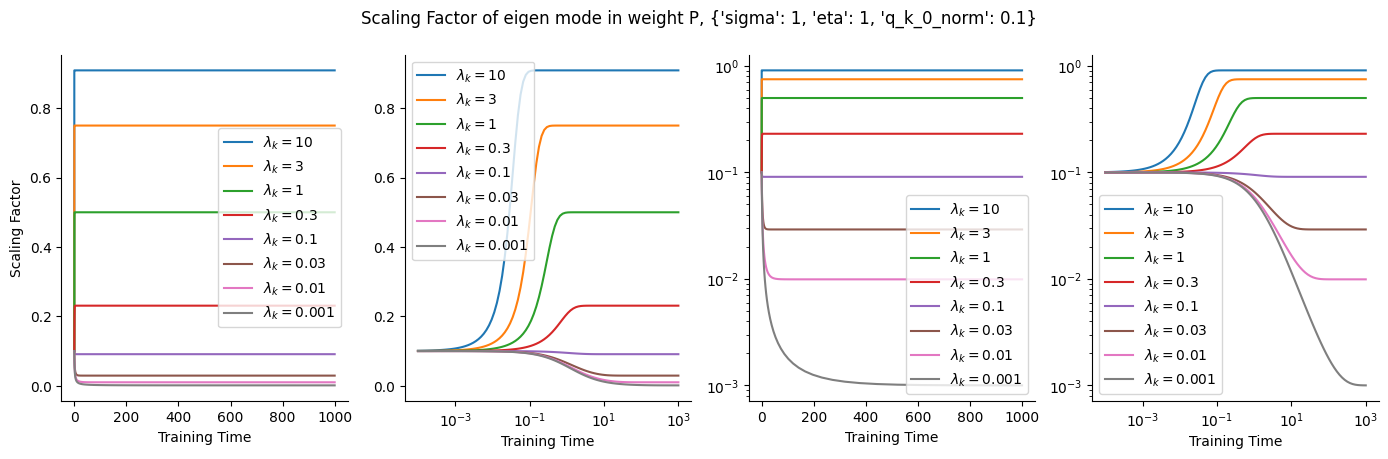

In [ ]:
# t_vec = torch.linspace(0.001, 100, 1000)
parameters = dict(sigma=1, eta=1, q_k_0_norm=0.1)
t_vec = torch.logspace(-4, 3, 100)
lambda_k_vec = [0.001, 0.01, 0.03, 0.1, 0.3, 1, 3, 10,][::-1]
figh, axs = plt.subplots(1, 4, figsize=(17, 4.5))
for ax, plot_fun in zip(axs, [plt.plot, plt.semilogx, plt.semilogy, plt.loglog]):
    plt.sca(ax)
    for lambda_k in lambda_k_vec:
        scaling_curve = symmetric_two_layer_learning_solu_scaling(t_vec, lambda_k=lambda_k, **parameters)
        plot_fun(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$', )
    plt.xlabel('Training Time')
    if ax == axs[0]:
        plt.ylabel('Scaling Factor')
    plt.legend()
plt.suptitle(f'Scaling Factor of eigen mode in weight P, {parameters}')
saveallforms(figdir, f'symm_lrncrv_scaling_sigma{parameters["sigma"]:.1f}_qk{parameters["q_k_0_norm"]:.2f}_fewer_lambda', figh)
plt.show()

### Older figures

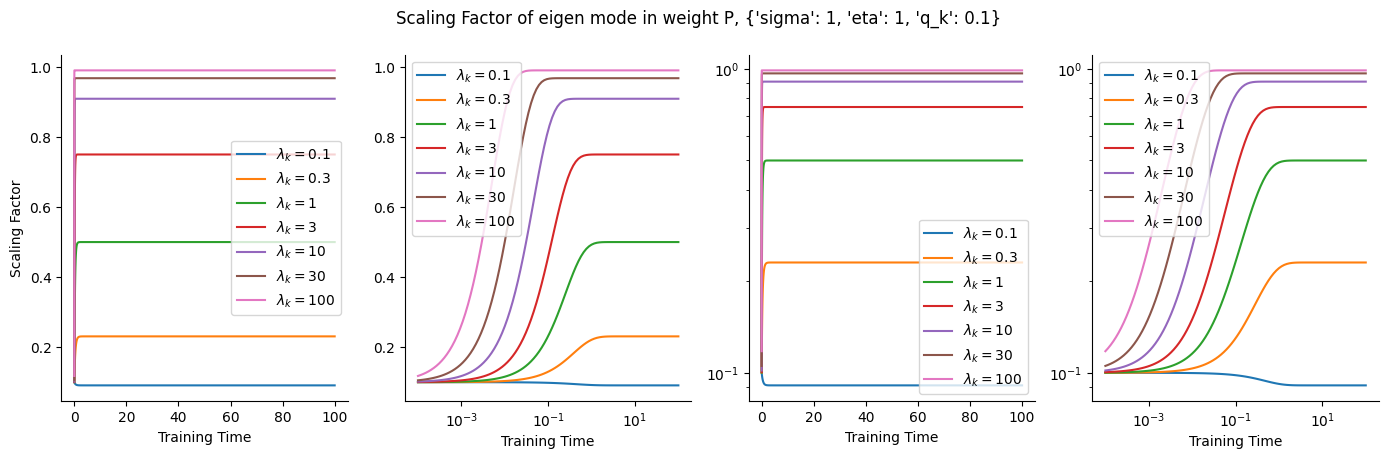

In [8]:
# t_vec = torch.linspace(0.001, 100, 1000)
parameters = dict(sigma=1, eta=1, q_k=0.1)
t_vec = torch.logspace(-4, 2, 100)
figh, axs = plt.subplots(1, 4, figsize=(17, 4.5))
for ax, plot_fun in zip(axs, [plt.plot, plt.semilogx, plt.semilogy, plt.loglog]):
    plt.sca(ax)
    for lambda_k in [0.1, 0.3, 1, 3, 10, 30, 100]:
        scaling_curve = onelayer_learning_solu_scaling(t_vec, lambda_k=lambda_k, **parameters)
        plot_fun(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$', )
    plt.xlabel('Training Time')
    if ax == axs[0]:
        plt.ylabel('Scaling Factor')
    plt.legend()
plt.suptitle(f'Scaling Factor of eigen mode in weight P, {parameters}')
saveallforms(figdir, f'one_layer_scaling_sigma{parameters["sigma"]:.1f}_qk{parameters["q_k"]:.2f}', figh)
plt.show()

/tmp/ipykernel_1277740/2036613631.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


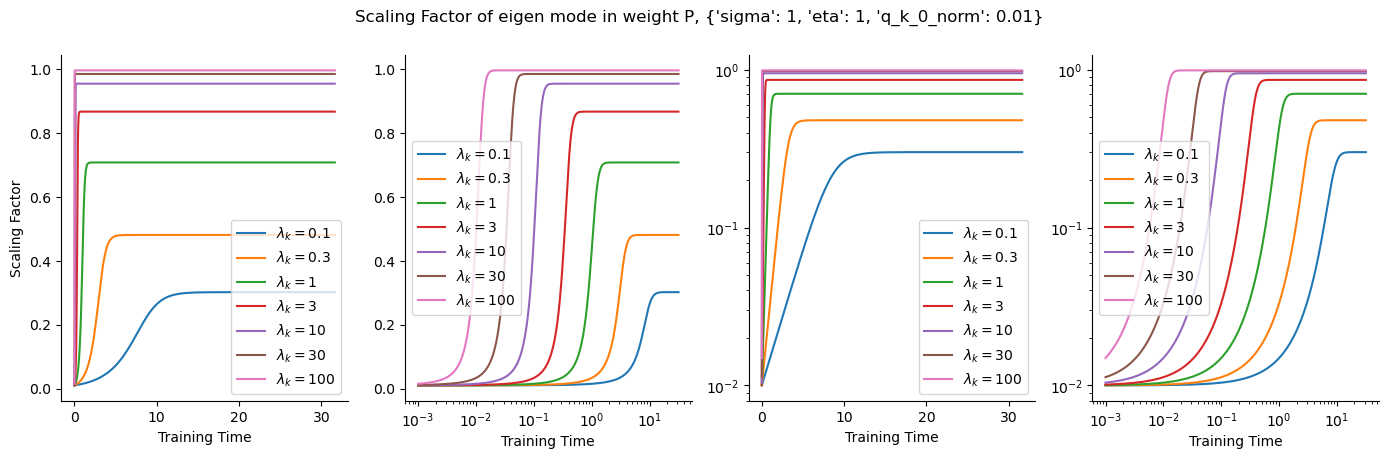

In [35]:
# t_vec = torch.linspace(0.001, 100, 1000)
parameters = dict(sigma=1, eta=1, q_k_0_norm=0.01)
t_vec = torch.logspace(-3, 1.5, 1000)
figh, axs = plt.subplots(1, 4, figsize=(17, 4.5))
for ax, plot_fun in zip(axs, [plt.plot, plt.semilogx, plt.semilogy, plt.loglog]):
    plt.sca(ax)
    for lambda_k in [0.1, 0.3, 1, 3, 10, 30, 100]:
        scaling_curve = symmetric_learning_solu_scaling(t_vec, lambda_k=lambda_k, **parameters)
        plot_fun(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$', )
    plt.xlabel('Training Time')
    if ax == axs[0]:
        plt.ylabel('Scaling Factor')
    plt.legend()
plt.suptitle(f'Scaling Factor of eigen mode in weight P, {parameters}')
saveallforms(figdir, f'symm_lrncrv_scaling_sigma{parameters["sigma"]:.1f}', figh)
plt.show()

/tmp/ipykernel_1277740/2036613631.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


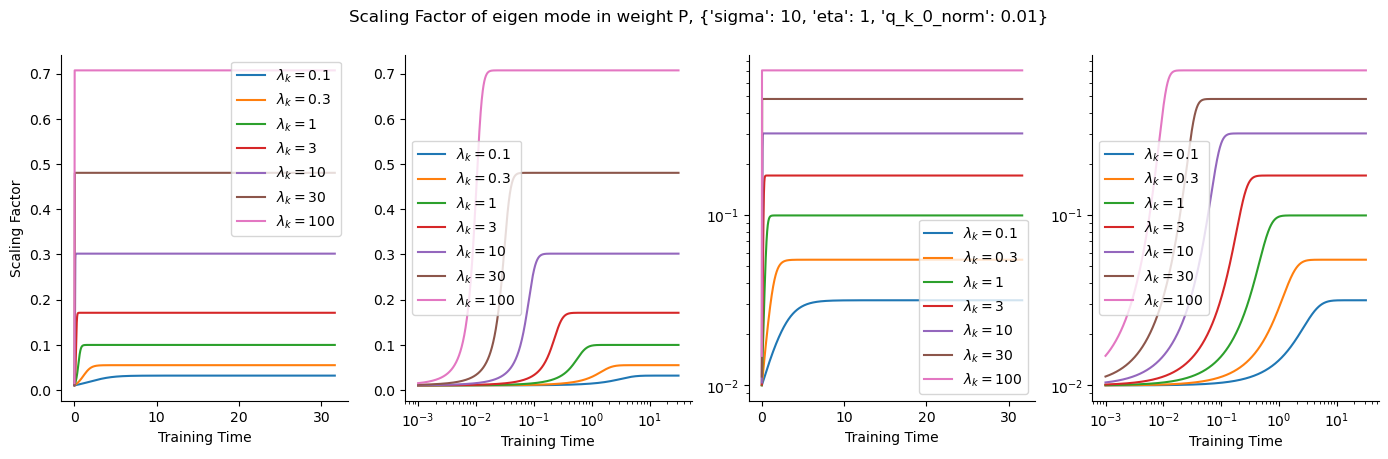

In [36]:
# t_vec = torch.linspace(0.001, 100, 1000)
parameters = dict(sigma=10, eta=1, q_k_0_norm=0.01)
t_vec = torch.logspace(-3, 1.5, 1000)
figh, axs = plt.subplots(1, 4, figsize=(17, 4.5))
for ax, plot_fun in zip(axs, [plt.plot, plt.semilogx, plt.semilogy, plt.loglog]):
    plt.sca(ax)
    for lambda_k in [0.1, 0.3, 1, 3, 10, 30, 100]:
        scaling_curve = symmetric_learning_solu_scaling(t_vec, lambda_k=lambda_k, **parameters)
        plot_fun(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$', )
    plt.xlabel('Training Time')
    if ax == axs[0]:
        plt.ylabel('Scaling Factor')
    plt.legend()
plt.suptitle(f'Scaling Factor of eigen mode in weight P, {parameters}')
saveallforms(figdir, f'symm_lrncrv_scaling_sigma{parameters["sigma"]:.1f}', figh)
plt.show()

/tmp/ipykernel_1277740/2036613631.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


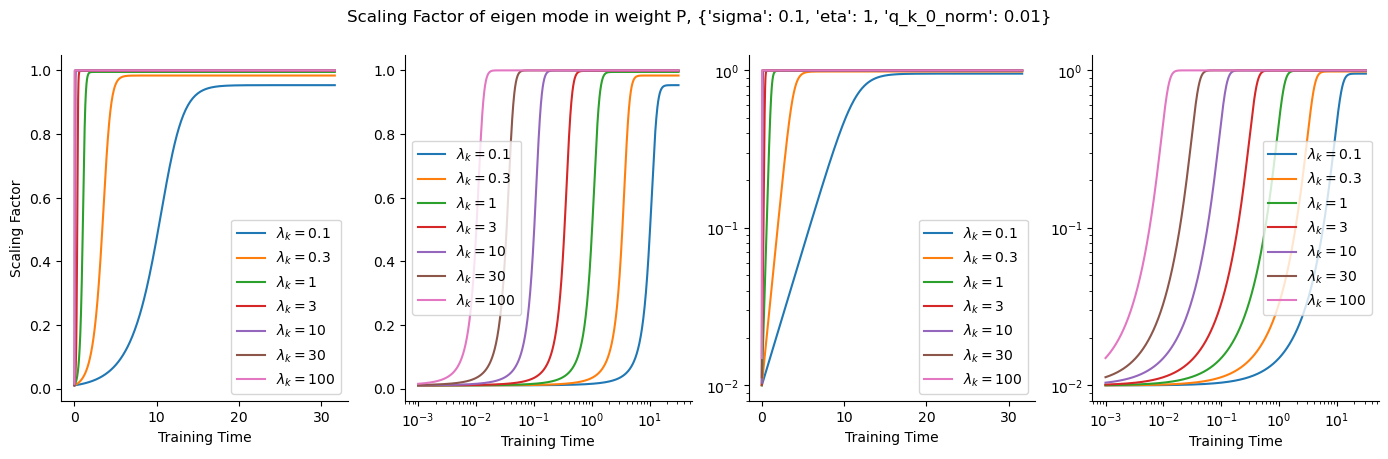

In [37]:
# t_vec = torch.linspace(0.001, 100, 1000)
parameters = dict(sigma=0.1, eta=1, q_k_0_norm=0.01)
t_vec = torch.logspace(-3, 1.5, 1000)
figh, axs = plt.subplots(1, 4, figsize=(17, 4.5))
for ax, plot_fun in zip(axs, [plt.plot, plt.semilogx, plt.semilogy, plt.loglog]):
    plt.sca(ax)
    for lambda_k in [0.1, 0.3, 1, 3, 10, 30, 100]:
        scaling_curve = symmetric_learning_solu_scaling(t_vec, lambda_k=lambda_k, **parameters)
        plot_fun(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$', )
    plt.xlabel('Training Time')
    if ax == axs[0]:
        plt.ylabel('Scaling Factor')
    plt.legend()
plt.suptitle(f'Scaling Factor of eigen mode in weight P, {parameters}')
saveallforms(figdir, f'symm_lrncrv_scaling_sigma{parameters["sigma"]:.1f}', figh)
plt.show()

/tmp/ipykernel_2443671/3011456134.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


Text(0, 0.5, 'Scaling Factor')

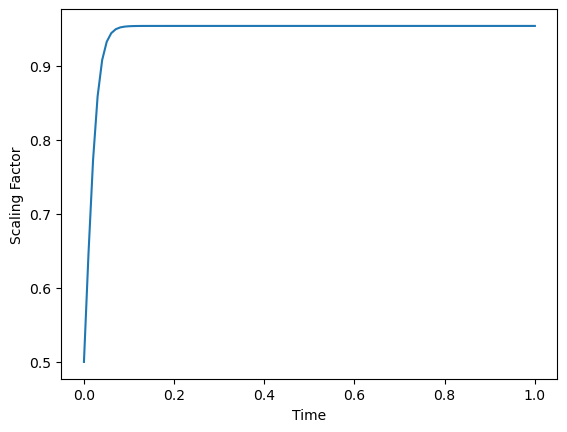

In [42]:
t_vec = torch.linspace(0, 1, 100)
scaling_curve = symmetric_learning_solu_scaling(t_vec, lambda_k=10, sigma=1, eta=1, q_k_0_norm=0.5)
plt.plot(t_vec, scaling_curve)
plt.xlabel('Time')
plt.ylabel('Scaling Factor')

/tmp/ipykernel_2443671/3011456134.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


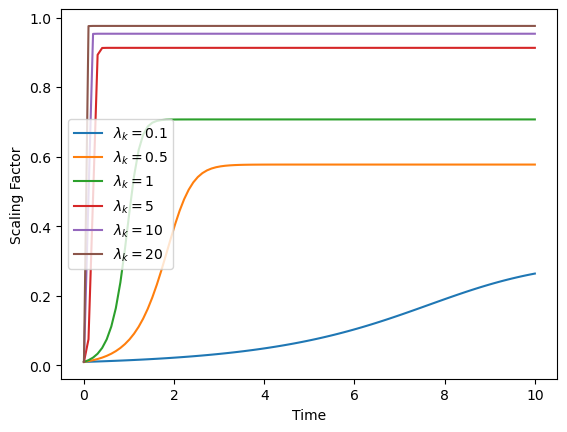

In [47]:
t_vec = torch.linspace(0, 10, 100)
for lambda_k in [0.1, 0.5, 1, 5, 10, 20]:
    scaling_curve = symmetric_learning_solu_scaling(t_vec, lambda_k=lambda_k, sigma=1, eta=1, q_k_0_norm=0.01)
    plt.plot(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$')
plt.xlabel('Time')
plt.ylabel('Scaling Factor')
plt.legend()

/tmp/ipykernel_1277740/2036613631.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


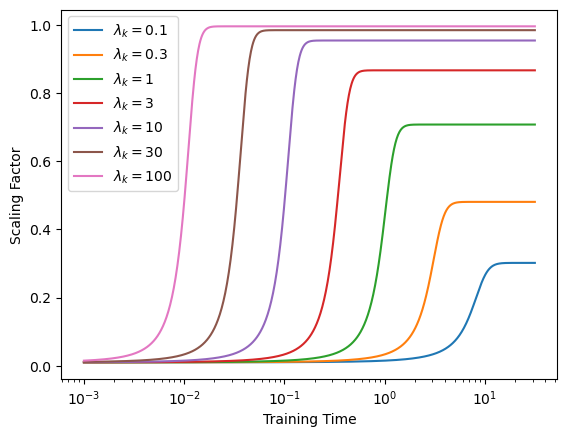

In [6]:
# t_vec = torch.linspace(0.001, 100, 1000)
t_vec = torch.logspace(-3, 1.5, 1000)
for lambda_k in [0.1, 0.3, 1, 3, 10, 30, 100]:
    scaling_curve = symmetric_learning_solu_scaling(t_vec, lambda_k=lambda_k, sigma=1, eta=1, q_k_0_norm=0.01)
    plt.semilogx(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$')
plt.xlabel('Training Time')
plt.ylabel('Scaling Factor')
plt.legend()

/tmp/ipykernel_2443671/3011456134.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


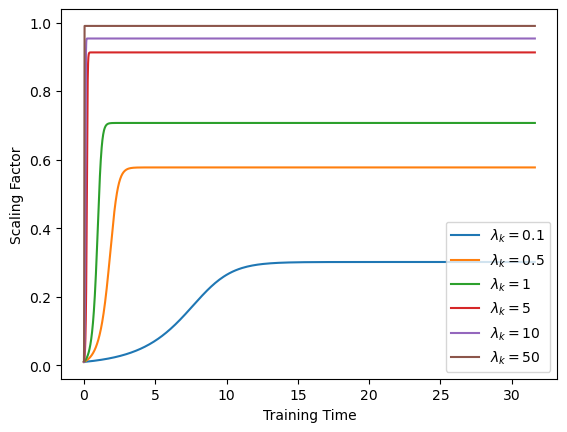

In [60]:
# t_vec = torch.linspace(0.001, 100, 1000)
t_vec = torch.logspace(-3, 1.5, 1000)
for lambda_k in [0.1, 0.5, 1, 5, 10, 50]:
    scaling_curve = symmetric_learning_solu_scaling(t_vec, lambda_k=lambda_k, sigma=1, eta=1, q_k_0_norm=0.01)
    plt.plot(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$')
plt.xlabel('Training Time')
plt.ylabel('Scaling Factor')
plt.legend()

/tmp/ipykernel_1277740/2036613631.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


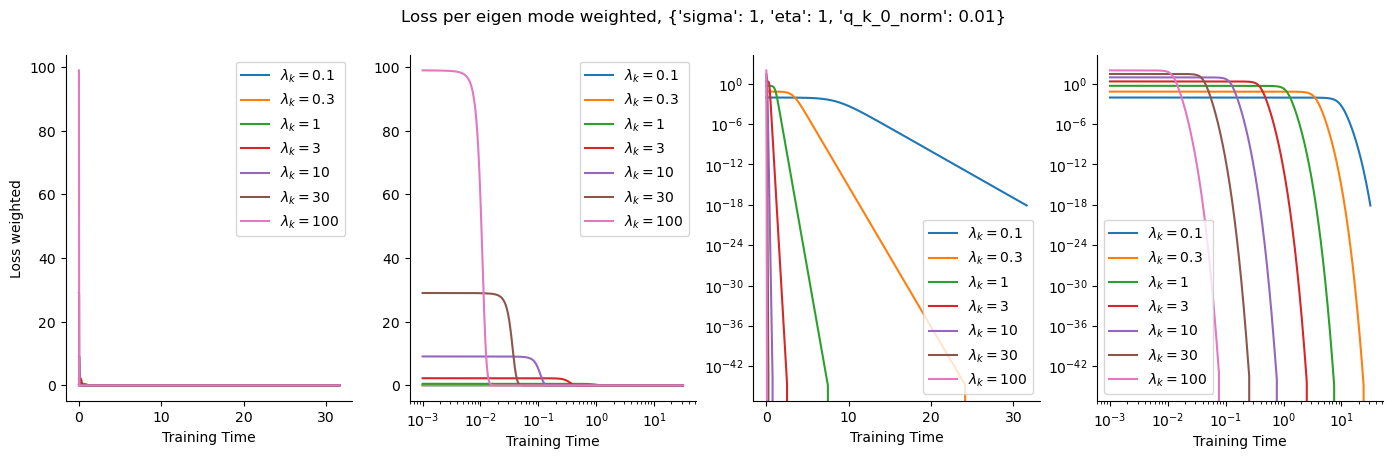

In [38]:
# t_vec = torch.linspace(0.001, 100, 1000)
parameters = dict(sigma=1, eta=1, q_k_0_norm=0.01)
t_vec = torch.logspace(-3, 1.5, 1000)
figh, axs = plt.subplots(1, 4, figsize=(17, 4.5))
for ax, plot_fun in zip(axs, [plt.plot, plt.semilogx, plt.semilogy, plt.loglog]):
    plt.sca(ax)
    for lambda_k in [0.1, 0.3, 1, 3, 10, 30, 100]:
        scaling_curve = symmetric_learning_loss_weighted(t_vec, lambda_k=lambda_k, **parameters)
        plot_fun(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$', )
    if ax == axs[0]:
        plt.ylabel('Loss weighted')
    plt.xlabel('Training Time')
    plt.legend()
plt.suptitle(f'Loss per eigen mode weighted, {parameters}')
saveallforms(figdir, f'symm_lrncrv_loss_per_mode_sigma{parameters["sigma"]:.1f}', figh)
plt.show()

/tmp/ipykernel_1277740/2036613631.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


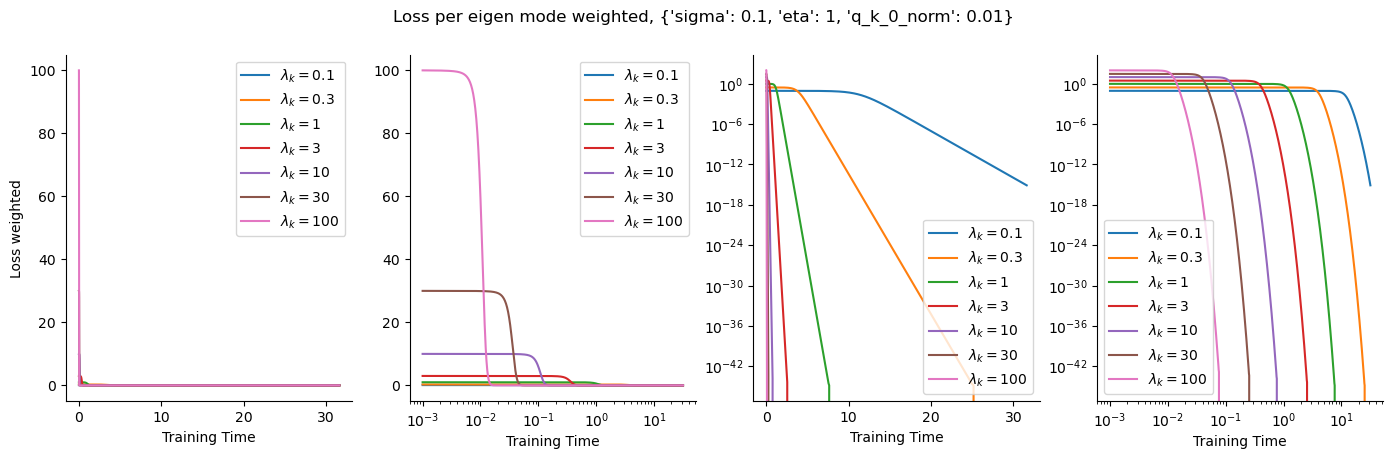

In [39]:
# t_vec = torch.linspace(0.001, 100, 1000)
parameters = dict(sigma=0.1, eta=1, q_k_0_norm=0.01)
t_vec = torch.logspace(-3, 1.5, 1000)
figh, axs = plt.subplots(1, 4, figsize=(17, 4.5))
for ax, plot_fun in zip(axs, [plt.plot, plt.semilogx, plt.semilogy, plt.loglog]):
    plt.sca(ax)
    for lambda_k in [0.1, 0.3, 1, 3, 10, 30, 100]:
        scaling_curve = symmetric_learning_loss_weighted(t_vec, lambda_k=lambda_k, **parameters)
        plot_fun(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$', )
    if ax == axs[0]:
        plt.ylabel('Loss weighted')
    plt.xlabel('Training Time')
    plt.legend()
plt.suptitle(f'Loss per eigen mode weighted, {parameters}')
saveallforms(figdir, f'symm_lrncrv_loss_per_mode_sigma{parameters["sigma"]:.1f}', figh)
plt.show()

/tmp/ipykernel_1277740/2036613631.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


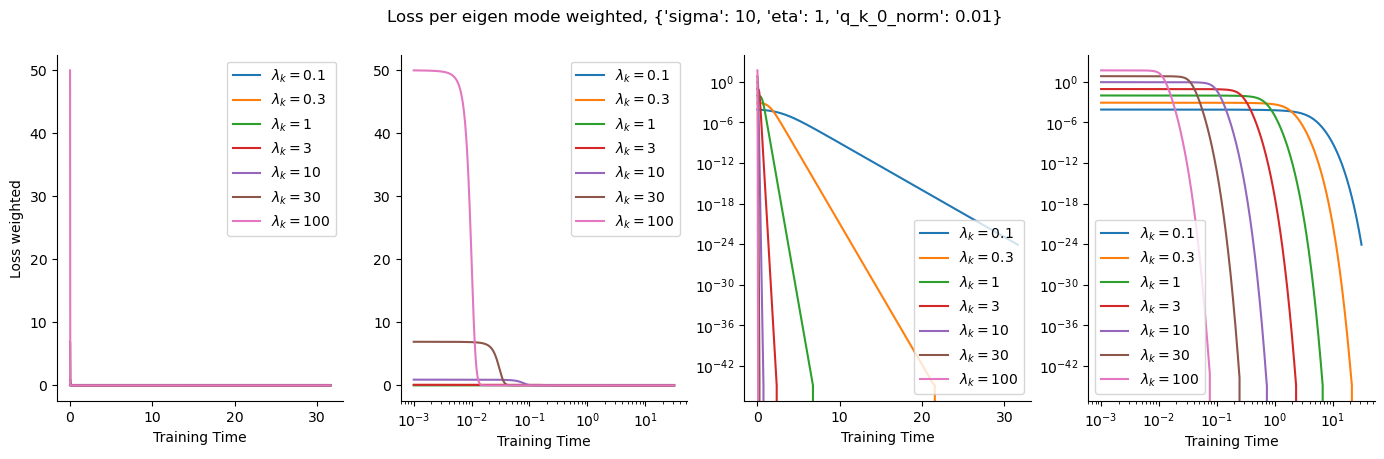

In [40]:
# t_vec = torch.linspace(0.001, 100, 1000)
parameters = dict(sigma=10, eta=1, q_k_0_norm=0.01)
t_vec = torch.logspace(-3, 1.5, 1000)
figh, axs = plt.subplots(1, 4, figsize=(17, 4.5))
for ax, plot_fun in zip(axs, [plt.plot, plt.semilogx, plt.semilogy, plt.loglog]):
    plt.sca(ax)
    for lambda_k in [0.1, 0.3, 1, 3, 10, 30, 100]:
        scaling_curve = symmetric_learning_loss_weighted(t_vec, lambda_k=lambda_k, **parameters)
        plot_fun(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$', )
    if ax == axs[0]:
        plt.ylabel('Loss weighted')
    plt.xlabel('Training Time')
    plt.legend()
plt.suptitle(f'Loss per eigen mode weighted, {parameters}')
saveallforms(figdir, f'symm_lrncrv_loss_per_mode_sigma{parameters["sigma"]:.1f}', figh)
plt.show()

/tmp/ipykernel_2443671/2036613631.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


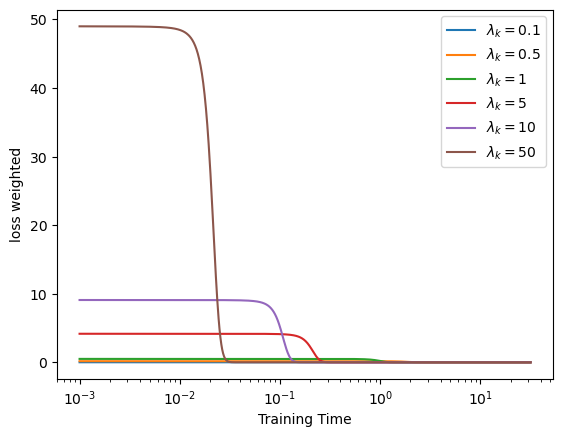

In [74]:
# t_vec = torch.linspace(0.001, 100, 1000)
t_vec = torch.logspace(-3, 1.5, 1000)
for lambda_k in [0.1, 0.5, 1, 5, 10, 50]:
    scaling_curve = symmetric_learning_loss_weighted(t_vec, lambda_k=lambda_k, sigma=1, eta=1, q_k_0_norm=0.01)
    plt.semilogx(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$')
plt.xlabel('Training Time')
plt.ylabel('loss weighted')
plt.legend()

/tmp/ipykernel_2443671/2036613631.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


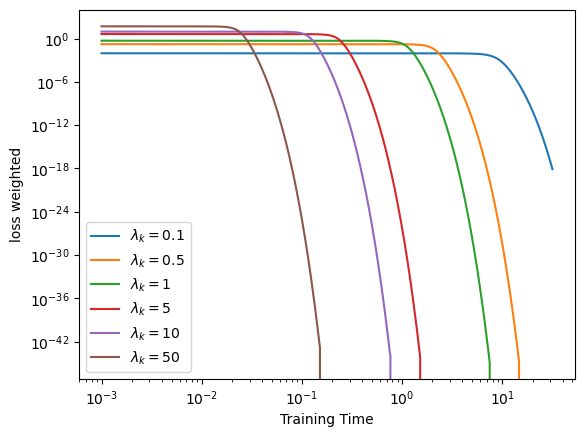

In [75]:
# t_vec = torch.linspace(0.001, 100, 1000)
t_vec = torch.logspace(-3, 1.5, 1000)
for lambda_k in [0.1, 0.5, 1, 5, 10, 50]:
    scaling_curve = symmetric_learning_loss_weighted(t_vec, lambda_k=lambda_k, sigma=1, eta=1, q_k_0_norm=0.01)
    plt.loglog(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$')
plt.xlabel('Training Time')
plt.ylabel('loss weighted')
plt.legend()

/tmp/ipykernel_2443671/2036613631.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


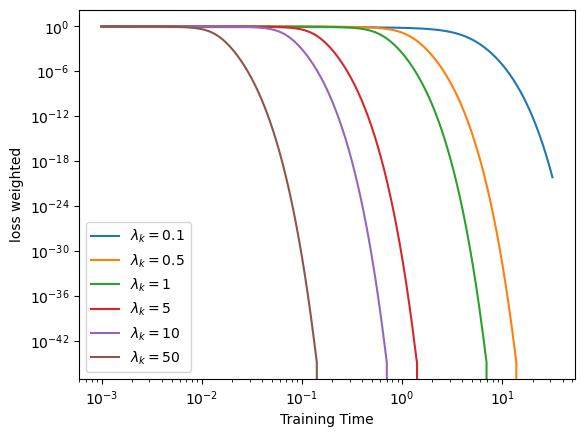

In [72]:
# t_vec = torch.linspace(0.001, 100, 1000)
t_vec = torch.logspace(-3, 1.5, 1000)
for lambda_k in [0.1, 0.5, 1, 5, 10, 50]:
    scaling_curve = symmetric_learning_loss(t_vec, lambda_k=lambda_k, sigma=1, eta=1, q_k_0_norm=0.1)
    plt.loglog(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$')
plt.xlabel('Training Time')
plt.ylabel('loss weighted')
plt.legend()

### Analytical solution for empirical

In [ ]:
W_init = th.randn(n_dim, n_dim).to(device) / math.sqrt(n_dim)
# assume we got it from above
# dev_k = (W_star_solu - W_init).pow(2).mean().sqrt()
V0 = (W_init @ U) # (n_dim, n_dim)
V_optim = U * (Lambda / (Lambda + sigma ** 2))[None, :] # (n_dim, n_dim)
delta_k = (V_optim - V0).pow(2).mean(dim=0) # (n_dim, ) # not sure it's sum or mean
delta_k_weighted = delta_k * (Lambda + sigma ** 2) # (n_dim, )

eta = 0.1
t_vec = th.logspace(-3, 2, 1000).to(device) # (n_time, )
exp_fun = th.exp(-4 * eta * t_vec[:, None] * (Lambda + sigma ** 2)[None, :]) # (n_time, n_dim)
loss_theory = exp_fun @ delta_k_weighted # (n_time, )

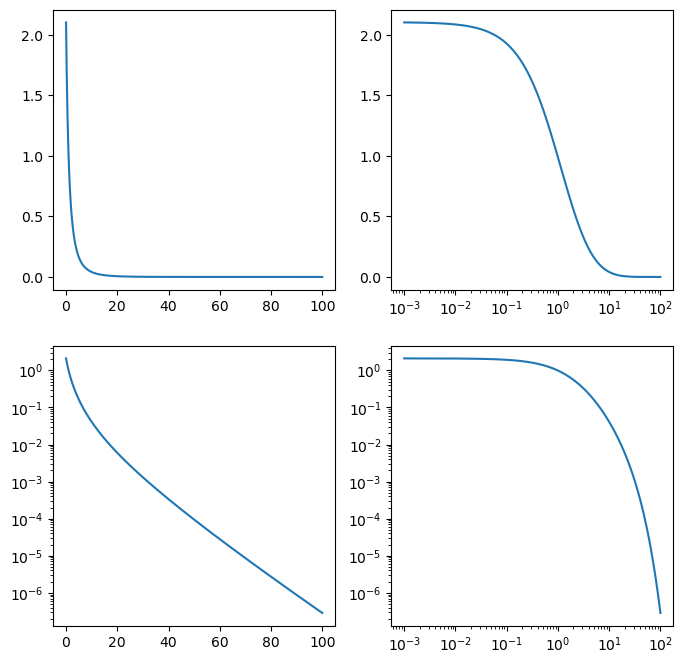

In [ ]:
figh, axs = plt.subplots(2,2,figsize=(8, 8))
axs = axs.flatten()
for i, plot_fun in enumerate([plt.plot, plt.semilogx, plt.semilogy, plt.loglog]):
    plt.sca(axs[i])
    plot_fun(t_vec.cpu().numpy(), loss_theory.cpu().numpy())
plt.show()